In [1]:
# Helpful statement for debugging, prints the thing entered as x and the output, i.e.,
# debugPrint(1+1) will output '1+1 [int] = 2'
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
    
    
import os
import os, sys
# sys.path.append(os.path.join('~/dev/pytorchSPH/', "lib"))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm.notebook import trange, tqdm
import yaml
%matplotlib notebook
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch
from torch_geometric.nn import radius
from torch_geometric.nn import SplineConv, fps, global_mean_pool, radius_graph, radius
from torch_scatter import scatter

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

import torch
# import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# TODO:
1. Add kinematic visocisty
2. Backport velocity diffusion to DFSPH code (own module)
3. IMPROVE PERFORMANCE
4. Add drag forces
5. delta sph with boundary integrals?!
6. setup dambreak with obstacle
7. setup flow past cylinder
8. add wcsph (müller)
9. add compressible sph
10. setup shockwave scenario for compressible sph

In [3]:
from src.deltaSPH import deltaSPHSimulation

In [4]:
config = 'configs/oscillating_drop_deltasph.toml'
with open(config, 'r') as file:
    tomlConfig = file.read()
parsedConfig = tomli.loads(tomlConfig)

In [5]:
sphSimulation = deltaSPHSimulation(parsedConfig)
sphSimulation.initializeSimulation()

/home/winchenbach/dev/pytorchSPH2/src/util.py:91: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  requiredSlices = torch.ceil(diff / packing / support).type(torch.int64) // 2


In [6]:
positions = sphSimulation.simulationState['fluidPosition']
velocities = sphSimulation.simulationState['fluidVelocity']

sigma = 1

velocities[:,0] = sigma * positions[:,0]
velocities[:,1] = -sigma * positions[:,1]

<IPython.core.display.Javascript object>


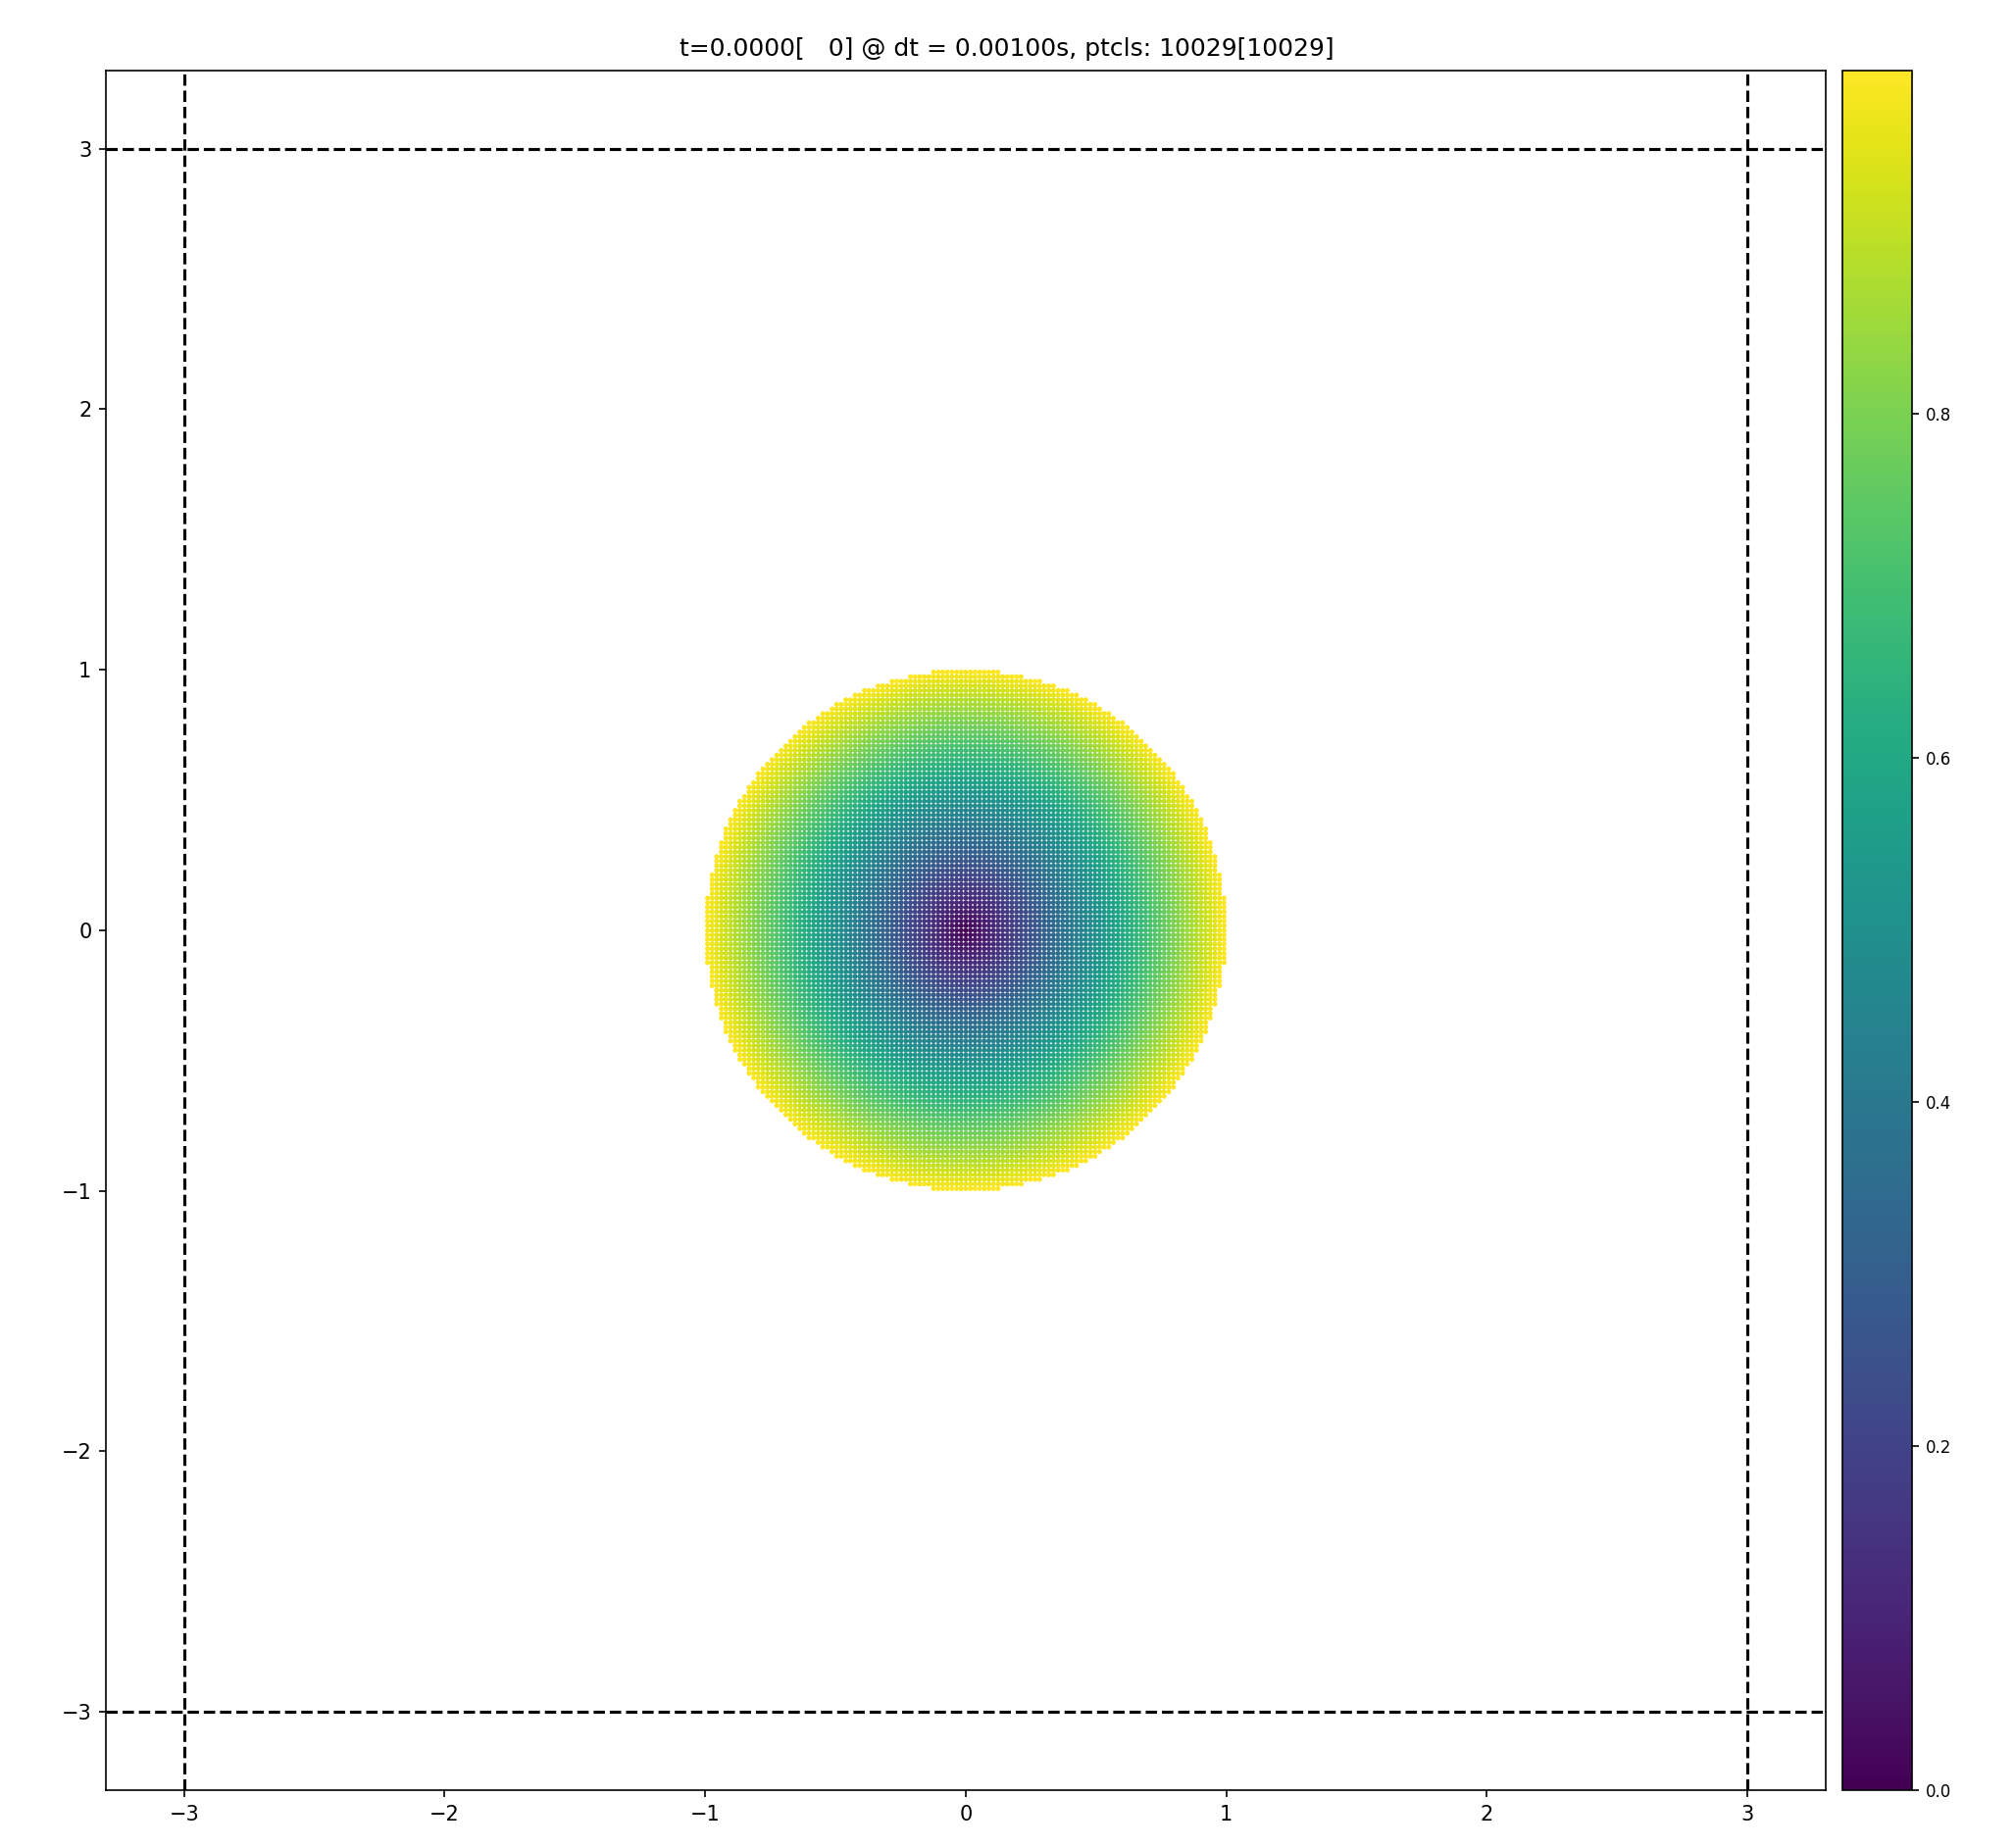

In [7]:
fig, axis = sphSimulation.createPlot(plotScale = 2, plotSolids = False, plotDomain = True)
state = sphSimulation.simulationState

positions = state['fluidPosition'].detach().cpu().numpy()
data = state['fluidDensity'].detach().cpu().numpy()

positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
data2 = sphSimulation.boundaryModule.boundaryDensity.detach().cpu().numpy()

# data2 = torch.linalg.norm(sphSimulation.boundaryModule.boundaryVelocity, dim=1).detach().cpu().numpy()
data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()

# positions = np.vstack((positions, positions2))
# data = np.hstack((data, data2))

sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 2)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

# quiverData = state['fluidUpdate'].detach().cpu().numpy()
# qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
#                       scale_units='xy', scale = 0.1) #scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)

fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
if 'densityErrors' in state and not 'divergenceErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
if 'divergenceErrors' in state and not 'densityErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
if 'densityErrors' in state and 'divergenceErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

fig.tight_layout()



In [8]:
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
path = './output/%s - %s/' % (config.split('/')[-1].split('.')[0], timestamp)
if not os.path.exists(path):
    os.makedirs(path)

In [10]:
for i in tqdm(range(4096 * 4)):
    sphSimulation.integrate()
    if i  % 1 == 0:
        state = sphSimulation.simulationState
        positions = state['fluidPosition'].detach().cpu().numpy()

        positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
        
        data = state['fluidDensity'].detach().cpu().numpy()
        data2 = sphSimulation.boundaryModule.boundaryDensity.detach().cpu().numpy()
        
#         data2 = torch.linalg.norm(sphSimulation.boundaryModule.boundaryVelocity, dim=1).detach().cpu().numpy()
        data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
#         data = torch.linalg.norm(state['fluidUpdate'], dim=1).detach().cpu().numpy()
        
#         data = sphSimulation.deltaSPH.pressure.detach().cpu().numpy()
#         data2 = sphSimulation.boundaryModule.pressure.detach().cpu().numpy()

#         positions = np.vstack((positions, positions2))
#         data = np.hstack((data, data2))

        cbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
        sc.set_offsets(positions)
        sc.set_array(data)


        fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
        if 'densityErrors' in state and not 'divergenceErrors' in state:
            fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
        if 'divergenceErrors' in state and not 'densityErrors' in state:
            fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
        if 'densityErrors' in state and 'divergenceErrors' in state:
            fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))


        fig.canvas.draw()
        fig.canvas.flush_events()
        imagePath = path + '%05d.png' % state['timestep']
        plt.savefig(imagePath)

  0%|          | 0/16384 [00:00<?, ?it/s]

AttributeError: 'deltaSPHSimulation' object has no attribute 'center'

tensor([-27., -26., -25., -24., -23., -22., -21., -20., -19., -18., -17., -16.,
        -15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,
         -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,
          9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,
         21.,  22.,  23.,  24.,  25.,  26.,  27.])
dist [Tensor] = tensor([1.3477, 1.3229, 1.2987,  ..., 1.2987, 1.3229, 1.3477])


/tmp/ipykernel_3864776/4111061353.py:15: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  requiredSlices = torch.ceil(diff / packing / support).type(torch.int64) // 2


<IPython.core.display.Javascript object>


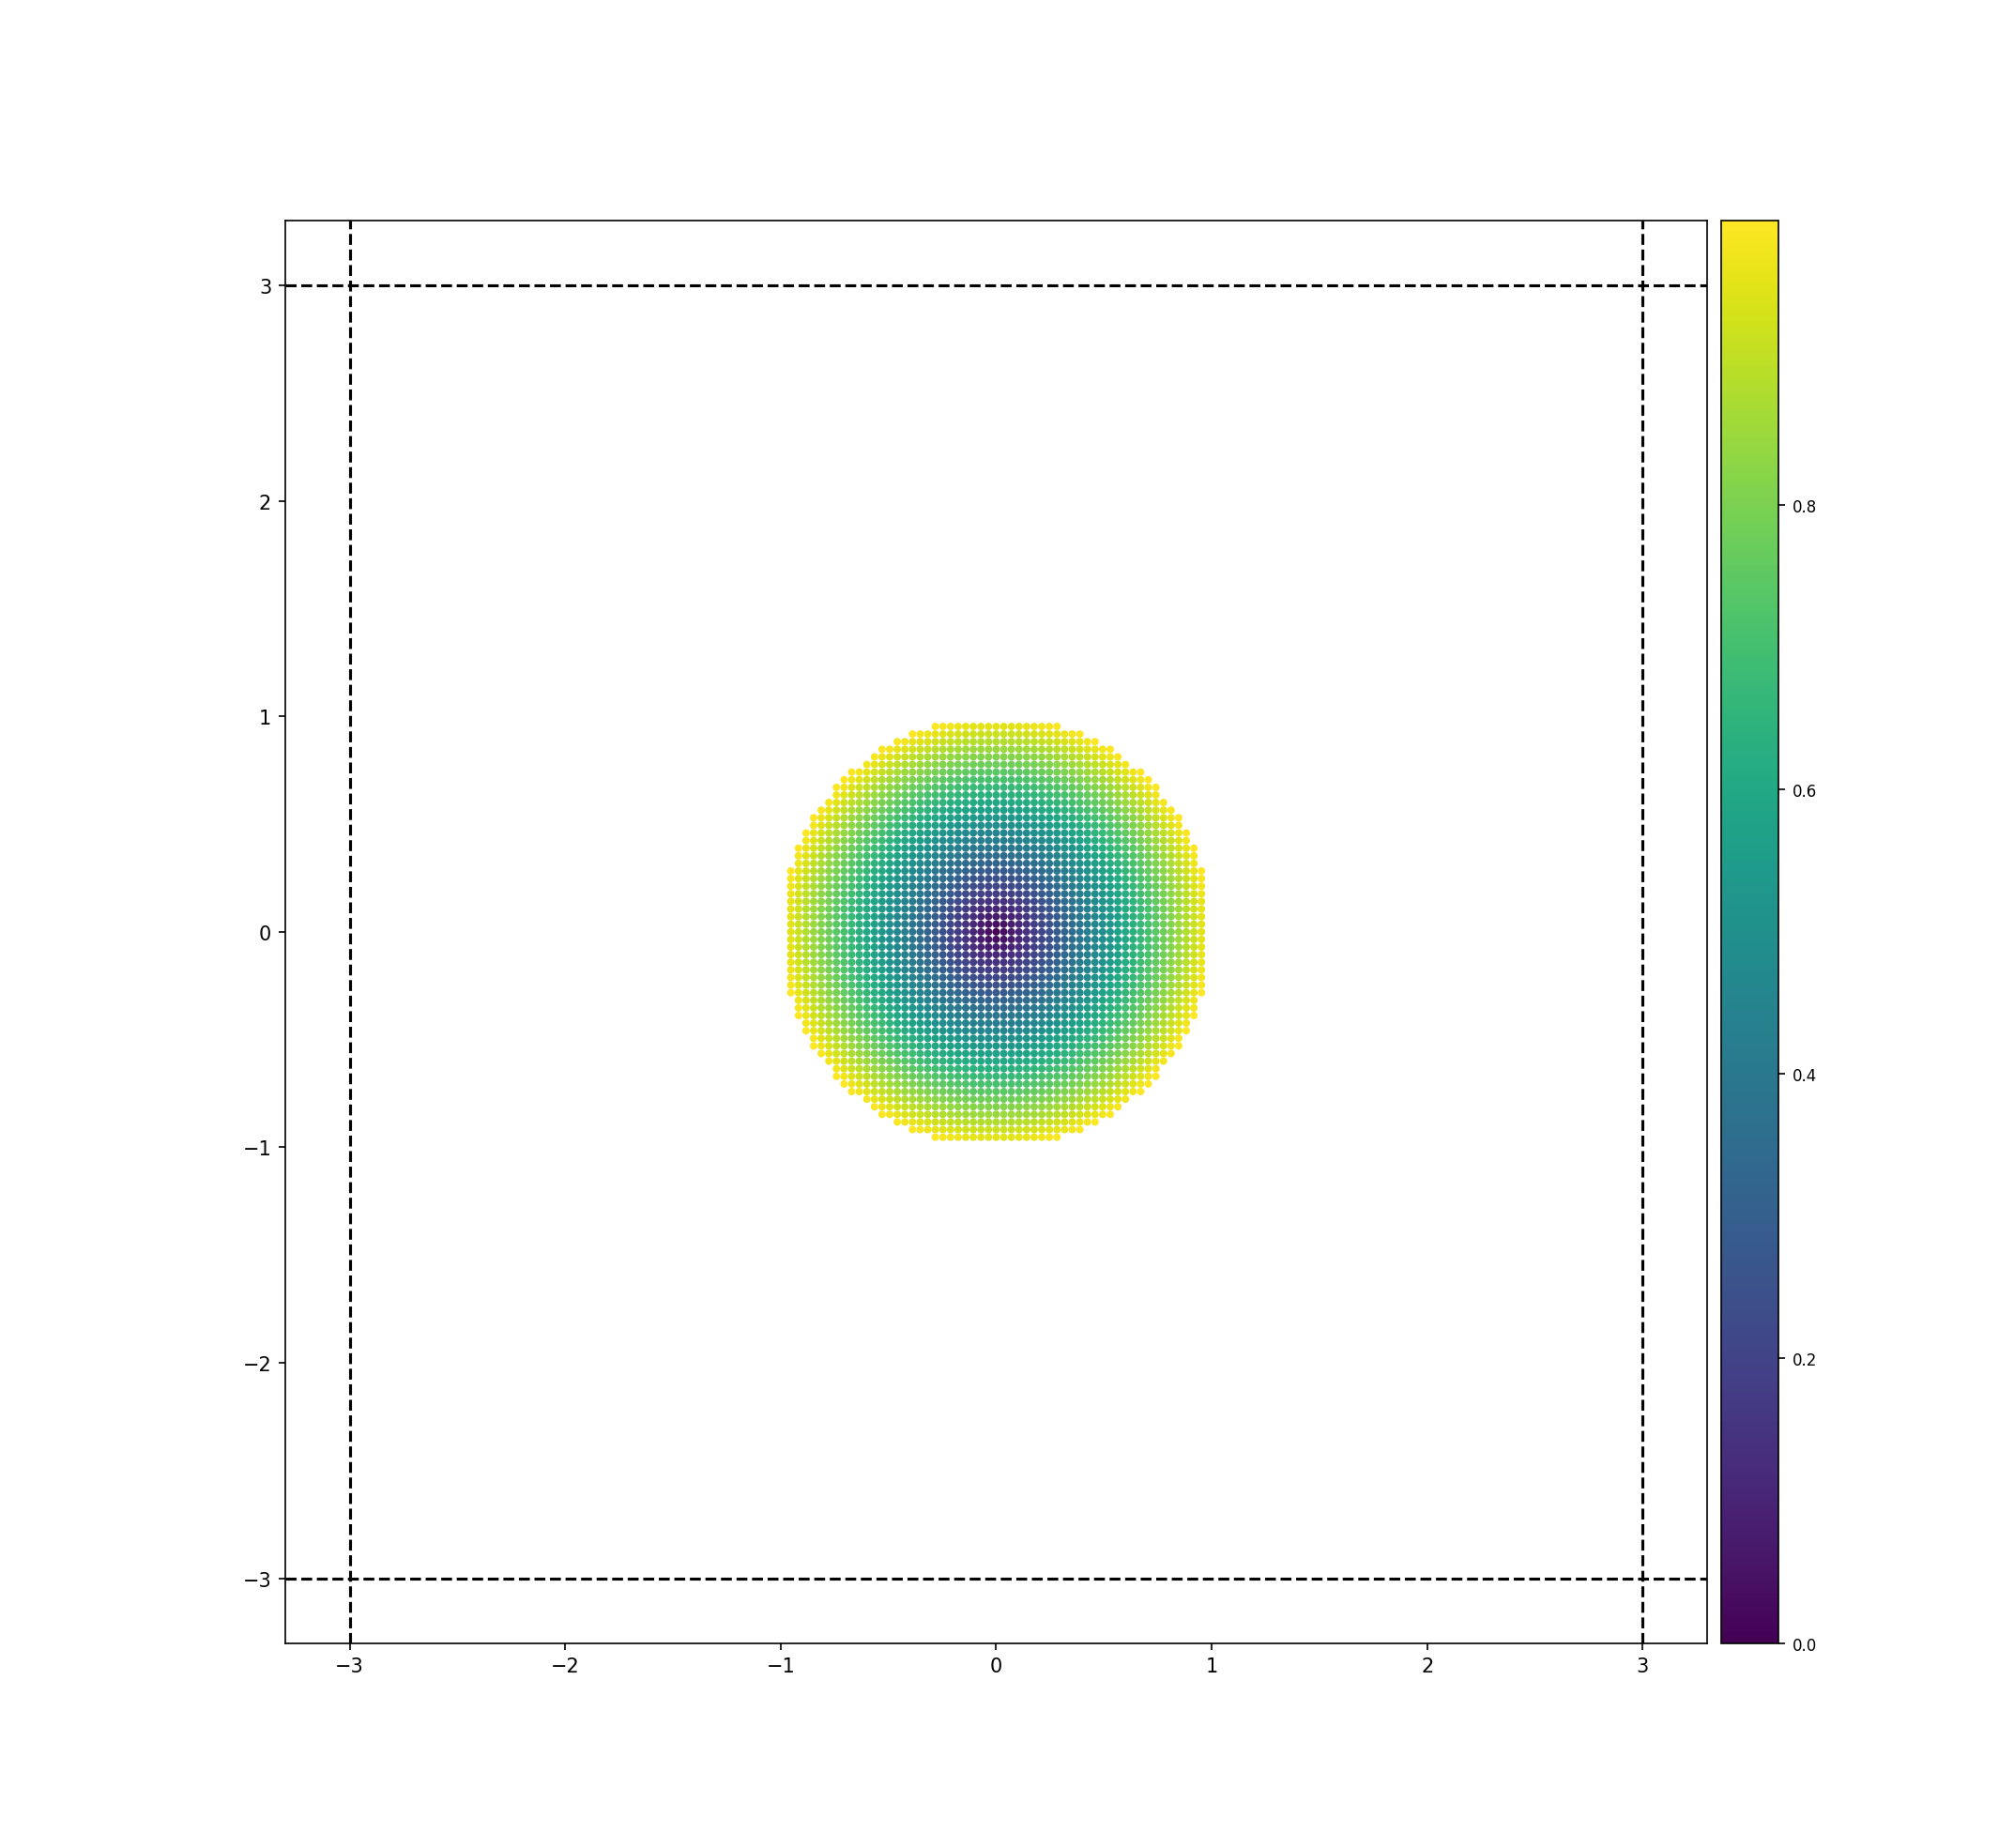

In [31]:

def genParticlesSphere(minCoord, maxCoord, radius, packing, support, dtype, device):
    with record_function('config - gen particles'):
        area = np.pi * radius**2
#         support = np.sqrt(area * config['targetNeighbors'] / np.pi)
        
        gen_position = lambda r, i, j: torch.tensor([r * i, r * j], dtype=dtype, device = device)
        
    #     packing *= support
        # debugPrint(minCoord)
        # debugPrint(maxCoord)
        
        rad = min(maxCoord[0] - minCoord[0], maxCoord[1] - minCoord[1]) / 2
        
        diff = maxCoord - minCoord
        requiredSlices = torch.ceil(diff / packing / support).type(torch.int64) // 2
        xi = torch.arange(requiredSlices[0] ).type(dtype).to(device)
        xi = torch.hstack((-torch.flip(xi[1:],(0,)), xi))
        yi = torch.arange(requiredSlices[1] ).type(dtype).to(device)
        yi = torch.hstack((-torch.flip(yi[1:],(0,)), yi))
        
        print(xi)
    
        xx, yy = torch.meshgrid(xi,yi, indexing = 'xy')
        positions = (packing * support) * torch.vstack((xx.flatten(), yy.flatten()))
        positions[:] += (maxCoord[:,None] + minCoord[:,None])/2
        
        dist = torch.linalg.norm(positions,dim=0)
        debugPrint(dist)
        positions = positions[:,dist < rad]
        
        # debugPrint(torch.min(positions))
        # debugPrint(torch.max(positions))
        return positions.mT
    
ptcls = genParticlesSphere(torch.tensor([-1,-1], dtype=torch.float32),torch.tensor([1,1], dtype=torch.float32), sphSimulation.config['particle']['radius'], sphSimulation.config['particle']['packing'], sphSimulation.config['particle']['support'], torch.float32, 'cpu')
fig, axis = sphSimulation.createPlot(plotScale = 2, plotSolids = False, plotDomain = True)
state = sphSimulation.simulationState

sc = axis[0,0].scatter(ptcls[:,0], ptcls[:,1], c = torch.linalg.norm(ptcls,dim=1), s = 8)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

In [10]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=False, profile_memory=True) as prof:    
    for i in range(1):
        with record_function("full Timestep"): 
            sphSimulation.integrate()
        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))

prof.export_chrome_trace("traceGPU.json")

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          full Timestep         0.81%       1.238ms        99.98%     152.565ms     152.565ms      21.40 Kb     -16.85 Mb             1  
                                  9 - density diffusion         0.03%      46.000us        30.00%      45.773ms      11.443ms     328.31 Kb        -544 b             4  
         density[diffusion] - compute density diffusion         0.39%     600.000us        29.96%      45.718ms      11.430ms     328.31 Kb    -135.00